In [3]:
# @title
# ==============================================================================
# Step 1: Install and Configure the Kaggle API
# ==============================================================================

# Install the Kaggle library quietly

!pip install kaggle -q

# Import necessary libraries

import os
from google.colab import userdata # The library for accessing secrets

# Set up the Kaggle API credentials from Colab Secrets

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

# Create the .kaggle directory and set permissions for the API client

!mkdir -p \~/.kaggle
!echo '{"username":"{userdata.get('KAGGLE_USERNAME')}","key":"{userdata.get('KAGGLE_KEY')}"}' \> \~/.kaggle/kaggle.json
!chmod 600 \~/.kaggle/kaggle.json

print("✅ Kaggle API configured successfully.")

# \==============================================================================

# Step 2: Download and Unzip the Chest X-Ray Dataset

# \==============================================================================

# API command for the "Chest X-Ray Images (Pneumonia)" dataset

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# The name of the zip file downloaded by the command above

zip_file_name = 'chest-xray-pneumonia.zip'

# Create a directory to store the unzipped image data

output_directory = 'chest_xray_data'
os.makedirs(output_directory, exist_ok=True)

# Unzip the file quietly into the specified directory

# This dataset has a nested structure, so we unzip directly to the output folder

print("\\nUnzipping dataset... This may take a moment.")
!unzip -q {zip_file_name} -d {output_directory}

# Clean up the downloaded zip file to save space

os.remove(zip_file_name)

print(f"✅ Dataset downloaded and unzipped to the '{output_directory}' directory.")
print("\\nVerifying the contents of the main data folder:")

# The actual images are in a subfolder named 'chest\_xray'

!ls -l {output_directory}/chest_xray

{"username":"{userdata.get(KAGGLE_USERNAME)}","key":"{userdata.get(KAGGLE_KEY)}"} > ~/.kaggle/kaggle.json
chmod: cannot access '~/.kaggle/kaggle.json': No such file or directory
✅ Kaggle API configured successfully.
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:26<00:00, 245MB/s]
100% 2.29G/2.29G [00:26<00:00, 93.3MB/s]
\nUnzipping dataset... This may take a moment.
✅ Dataset downloaded and unzipped to the 'chest_xray_data' directory.
\nVerifying the contents of the main data folder:
total 20
drwxr-xr-x 5 root root 4096 Oct  2 10:03 chest_xray
drwxr-xr-x 3 root root 4096 Oct  2 10:03 __MACOSX
drwxr-xr-x 4 root root 4096 Oct  2 10:03 test
drwxr-xr-x 4 root root 4096 Oct  2 10:03 train
drwxr-xr-x 4 root root 4096 Oct  2 10:03 val


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

In [5]:
base_dir = os.path.join(output_directory, 'chest_xray')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

img_size = (224, 224)  # EfficientNet default input size
batch_size = 32
epochs = 10

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
# Load Pretrained EfficientNetB0 and Add Custom Layers

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)


# Freeze base model layers
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
# Model Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 716ms/step - accuracy: 0.7239 - loss: 0.6043 - val_accuracy: 0.5000 - val_loss: 0.8320
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 626ms/step - accuracy: 0.7530 - loss: 0.5681 - val_accuracy: 0.5000 - val_loss: 0.8330
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 620ms/step - accuracy: 0.7322 - loss: 0.5888 - val_accuracy: 0.5000 - val_loss: 0.8524
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 625ms/step - accuracy: 0.7359 - loss: 0.5867 - val_accuracy: 0.5000 - val_loss: 0.8356
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 633ms/step - accuracy: 0.7326 - loss: 0.5831 - val_accuracy: 0.5000 - val_loss: 0.8415
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 622ms/step - accuracy: 0.7409 - loss: 0.5807 - val_accuracy: 0.5000 - val_loss: 0.8454
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 630ms/step - accuracy: 0.7509 - loss: 0.5653 - val_accuracy: 0.5000 - val_loss: 0.8354
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 622ms/step - accuracy: 0.7420 -

In [9]:
# Evaluation
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.2816 - loss: 1.0701
✅ Test Accuracy: 61.51%


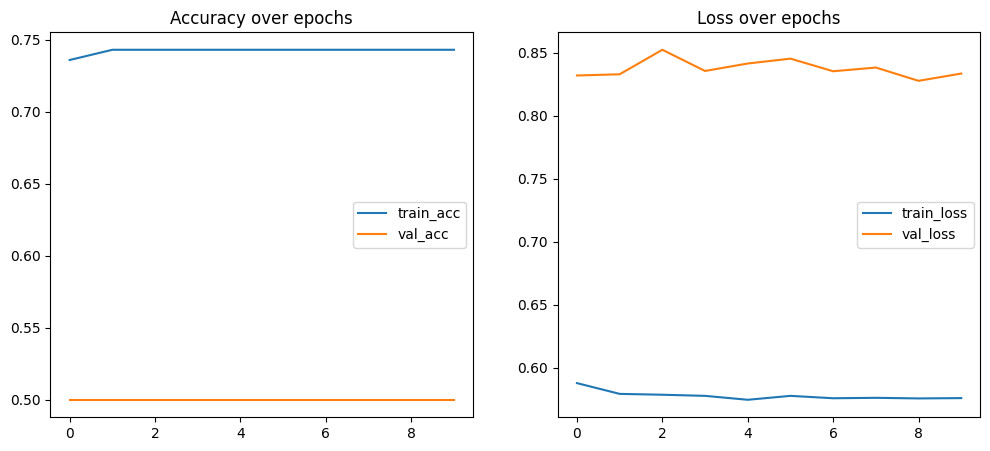

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [12]:
# Save the original model in TensorFlow SavedModel format
model.save("pneumonia_model.keras")
model.save("pneumonia_model.h5")
print("✅ Model saved successfully!")

✅ Model saved successfully!
